In [1]:
import numpy as np
import json

from wpg.wpg_uti_wf import plot_intensity_map
from felpy.utils.vis_utils import scatter_plot
from felpy.model.beamlines.exfel_spb.exfel_spb import Instrument

from felpy.model.beamlines.exfel_spb.methods import setup_spb, get_beamline_object

from felpy.model.src.coherent import construct_SA1_wavefront
from tqdm import tqdm
from wpg.wpg_uti_wf import plot_intensity_map
from felpy.model.materials.load_refl import load_refl, get_refl 

import multiprocessing as mpi
from felpy.utils.np_utils import memory_map, read_map

from functools import partial

from felpy.utils.vis_utils import exfel_c1, exfel_c2, exfel_c3, Grids
from labwork.about import dCache
from felpy.utils.os_utils import mkdir_p

from felpy.utils.os_utils import timing
from copy import deepcopy

from felpy.model.tools import propagation_parameters

In [2]:
ekev = 12.0
wfr0 = construct_SA1_wavefront(512, 512, ekev, 0.25)


spb0 = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_FAST.json",
                 ekev = ekev, 
                 apertures = False, 
                 surface = "real",                             
                 crop = ["d1"],
                 theta_HOM = 5e-05)

spb0.edit_propagation_parameters("d1", propagation_parameters(1,1,1,1, mode = 'fraunhofer'))

bl0 = spb0.bl
bl0.propagate(wfr0)
ii0 = wfr0.get_intensity().sum()



def get_transmitted_intensity(angle, ekev, ii0, VERBOSE = False):
    
    print("************")
    print("Angle: {}".format(angle))
    
    spb_surface = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_FAST.json", ekev = ekev, apertures = False, surface = "flat",
                                 crop = ["HOM1"], theta_HOM = angle)
    spb_surface.edit_propagation_parameters("d1", propagation_parameters(1,1,1,1, mode = 'fraunhofer'))

    spb_surface_bl = spb_surface.bl
    wfr_surface = construct_SA1_wavefront(512, 512, ekev, 0.25)
    spb_surface_bl.propagate(wfr_surface)
    #plot_intensity_map(wfr_surface)
    if VERBOSE:
        plot_intensity_map(wfr_surface)
    
    ii_surface = wfr_surface.get_intensity().sum()
    
    spb_aperture = setup_spb(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_FAST.json", ekev = ekev, apertures = True, surface = "real",
                             crop = ["HOM1"], theta_HOM = angle)
    
    spb_aperture.edit_propagation_parameters("d1", propagation_parameters(1,1,1,1, mode = 'fraunhofer'))

    spb_aperture_bl = spb_aperture.bl
    wfr_aperture = construct_SA1_wavefront(512, 512, ekev, 0.25)
    spb_aperture_bl.propagate(wfr_aperture)
    ii_aperture = wfr_aperture.get_intensity().sum()
    #print(spb_aperture.params['HOM1'])
    #plot_intensity_map(wfr_aperture)
    
    if ekev <= 7.5:
        material = "B4C"
    else: 
        material = "Ru"    

    
    refl = load_refl(material)
    expected_refl = get_refl(refl, ekev, angle)
    

    
    print("Expected Refl: ",expected_refl)
    print("Actual Refl: ", ii_surface/ii0)
    print("Refl w/ Ap: ", ii_aperture/ii0)
    
    del spb_surface, spb_aperture
    del wfr_surface, wfr_aperture
    
    return np.sqrt(ii_surface/ii0), np.sqrt(ii_aperture/ii0)
    
@timing
def batch_gti(angles, ekev, ii0):

    cpus = len(angles)
    pool = mpi.Pool(processes = cpus)
    partial_gti = partial(get_transmitted_intensity, ekev = ekev, ii0 = ii0)
    t_surface, t_aperture = pool.map(partial_gti, angles)

@timing
def loop_gti(angles, ekev, ii0):
    
    data = memory_map("./results/mirror_transmission_{}keV".format(ekev), shape = (len(angles),2))
    
    for i, angle in tqdm(enumerate(angles)):
        data[i, :] = get_transmitted_intensity(angle, ekev, ii0)
        
    


    

Initialising Single Particle Beamline
List of Elements: ['d1']


In [2]:
ekev = 12.0
 
from felpy.utils.vis_utils import Grids

def plot_downstream(angle, ekev, VERBOSE = False):
    
    print("************")
    print("Angle: {}".format(angle))
    
 
    bl = get_beamline_object(parameter_file = "/gpfs/exfel/data/user/guestt/FELpy/felpy/data/params/spb-sfx_nkb_FAST.json", ekev = ekev, apertures = True, surface = "real",
                             crop = ["d3"], theta_HOM = angle)
    
     
    wfr = construct_SA1_wavefront(512, 512, ekev, 0.25)
    bl.propagate(wfr)
    
    grid = Grids(scale = 2, global_aspect = 1.5)
    grid.create_grid(n=1,m=1)
    grid.add_global_colorbar(cmap = 'afmhot', clabel = "Intensity (a.u)", fontsize = 22)
    ax1 = grid.axes
    grid.set_fontsize(22)

    ax1.imshow(wfr.get_intensity().sum(-1), extent = [val*1e3 for val in wfr.extent], cmap = 'afmhot')
    ax1.text(ax1.get_xlim()[0], ax1.get_ylim()[0], "{:2} mrad".format(angle*1e3), va = 'bottom', ha = 'left', fontsize = 22, c = 'white')
    ax1.set_title("{} keV".format(ekev), fontsize = 22)
    grid.savefig("./gif_tmp/{:04.2}.png".format(angle))
    
@timing
def batch_gti(angles, ekev, ii0):

    cpus = len(angles)
    pool = mpi.Pool(processes = cpus)
    partial_gti = partial(plot_downstream, ekev = ekev, ii0 = ii0)
    pool.map(partial_gti, angles)

@timing
def loop_gti(angles, ekev, ii0):
    
    data = memory_map("./results/mirror_transmission_{}keV".format(ekev*1e3), shape = (len(angles),2))
    
    for i, angle in tqdm(enumerate(angles)):
        data[i, :] = plot_downstream(angle, ekev, ii0)
        
    


    

************
Angle: 1e-06
Initialising Single Particle Beamline
************
Angle: 0.00020929166666666665
Initialising Single Particle Beamline
************
Angle: 0.00041758333333333334
Initialising Single Particle Beamline
************
Angle: 0.000625875
Initialising Single Particle Beamline
************
Angle: 0.0008341666666666667
Initialising Single Particle Beamline
************
Angle: 0.0010424583333333332
Initialising Single Particle Beamline
************
Angle: 0.00125075
Initialising Single Particle Beamline
************
Angle: 0.0014590416666666664
Initialising Single Particle Beamline
************
Angle: 0.0016673333333333332
Initialising Single Particle Beamline
************
Angle: 0.001875625
Initialising Single Particle Beamline
************
Angle: 0.0020839166666666666
Initialising Single Particle Beamline
************
Angle: 0.002292208333333333
Initialising Single Particle Beamline
************
Angle: 0.0025005
Initialising Single Particle Beamline
************
Angle

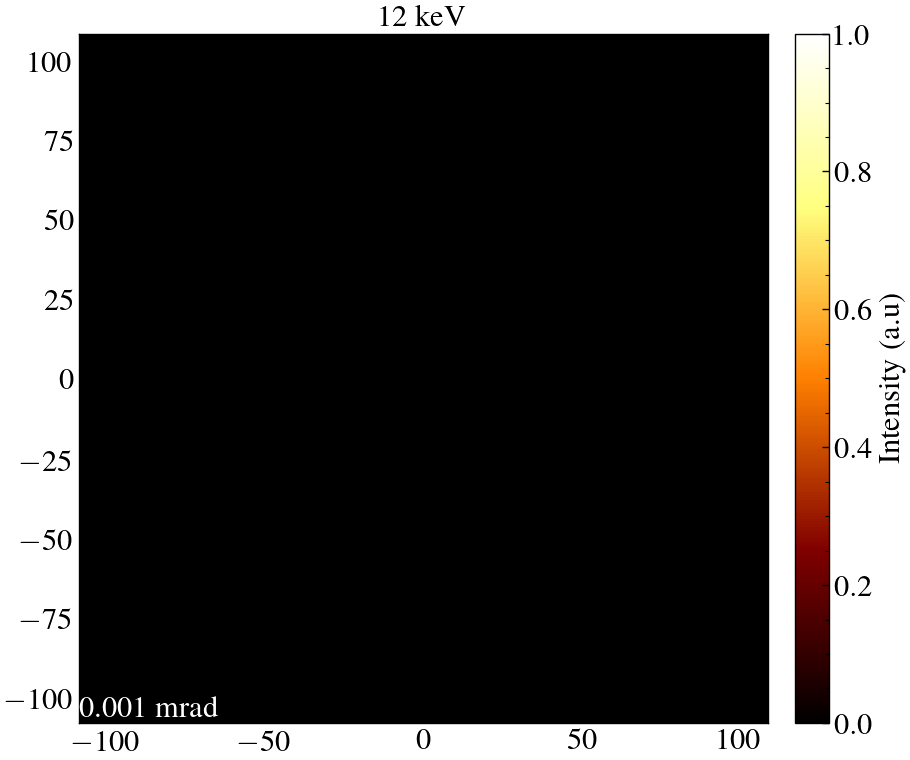

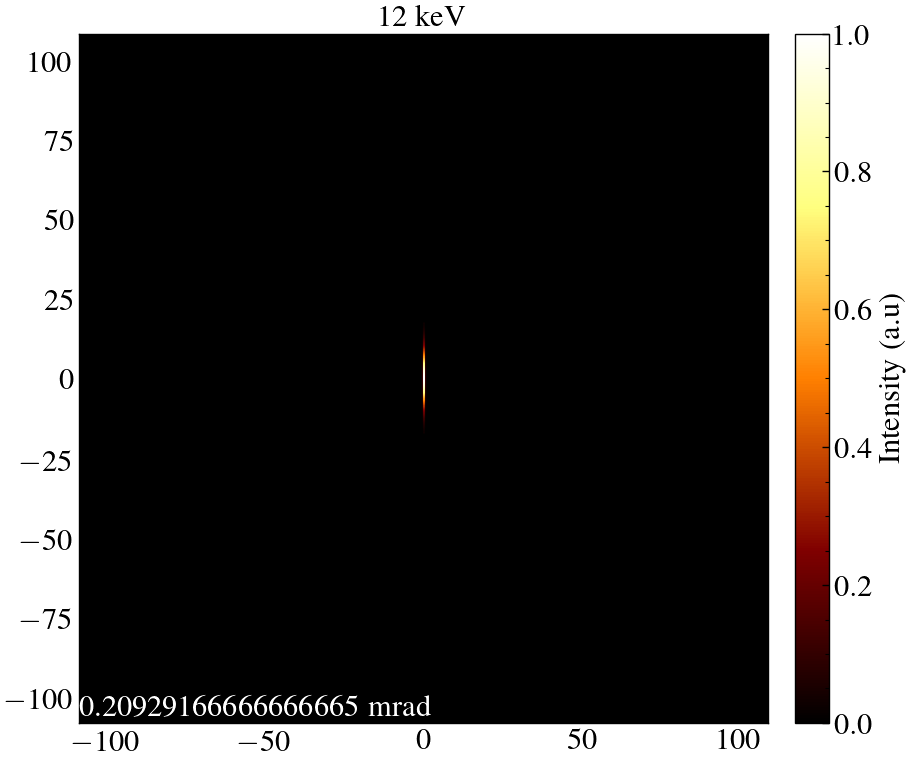

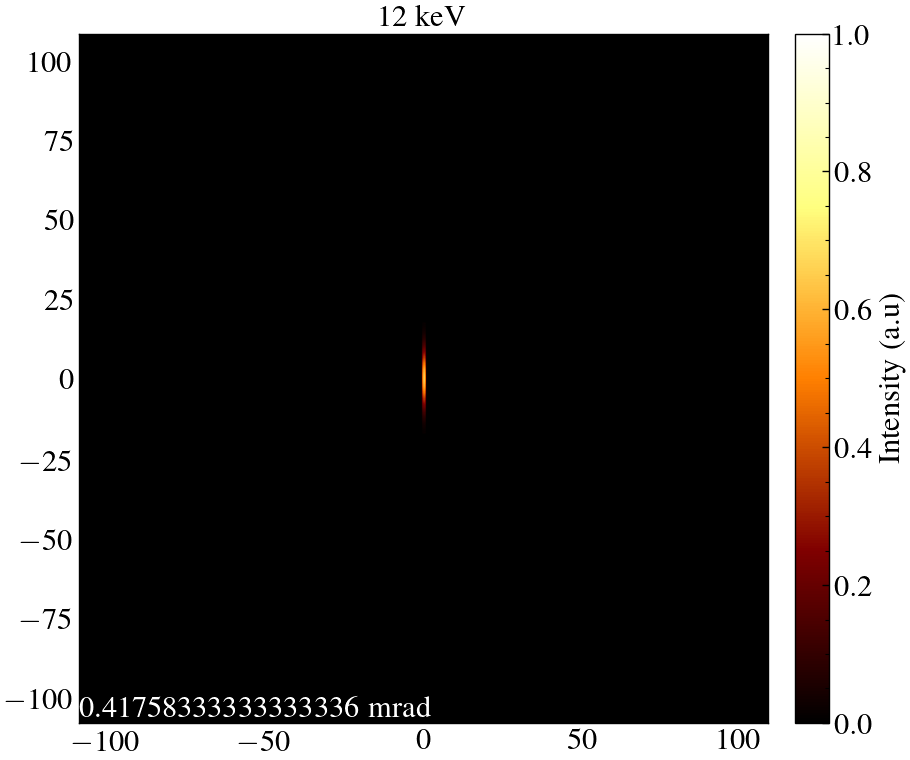

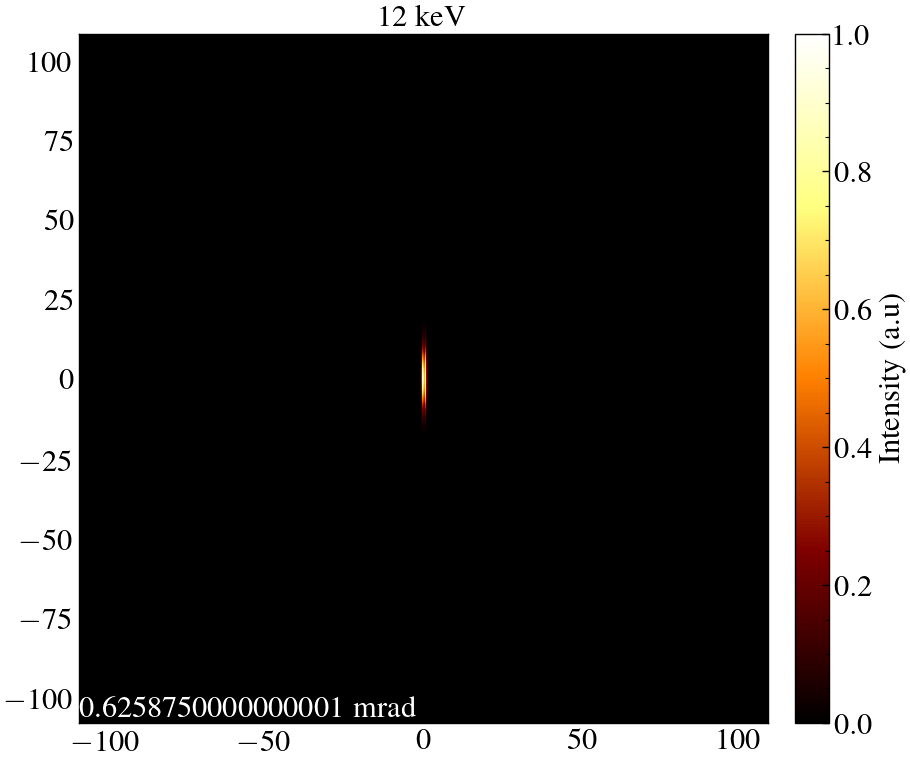

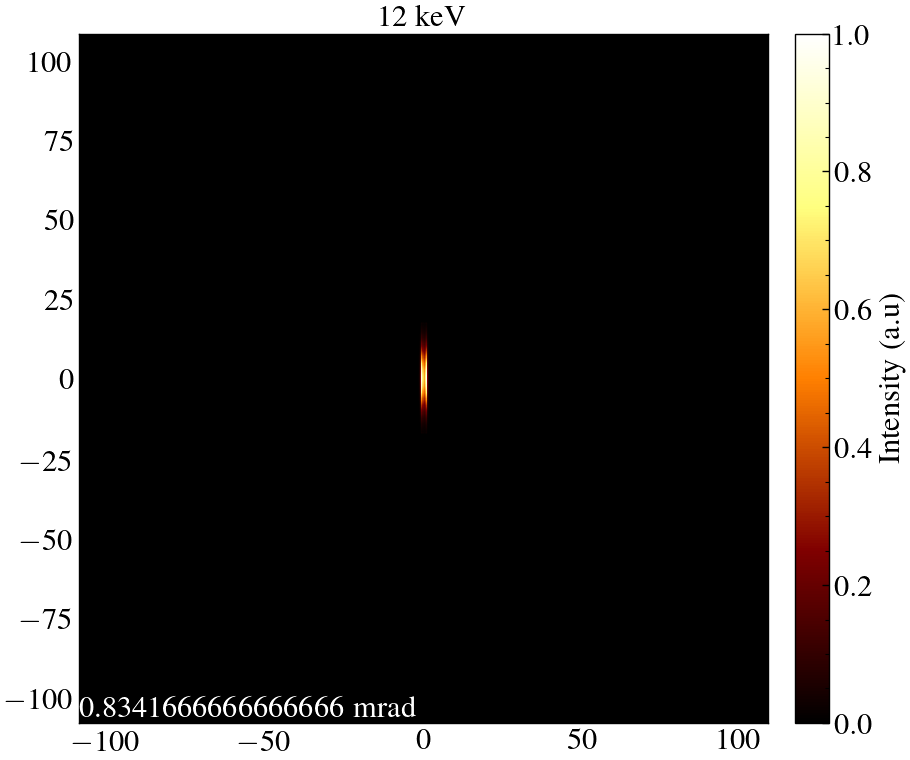

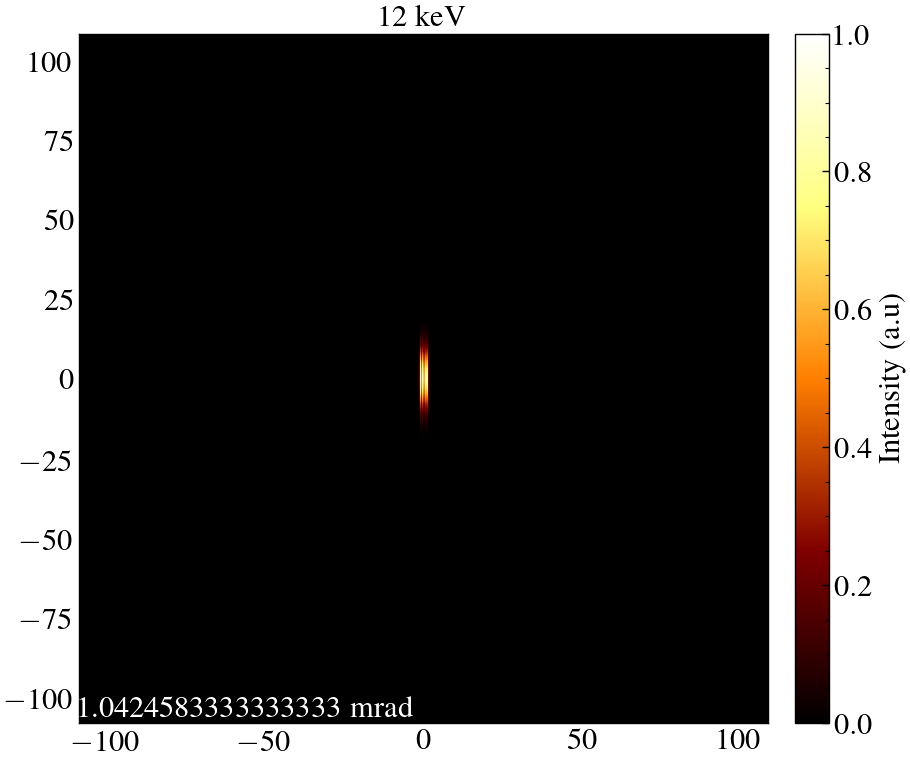

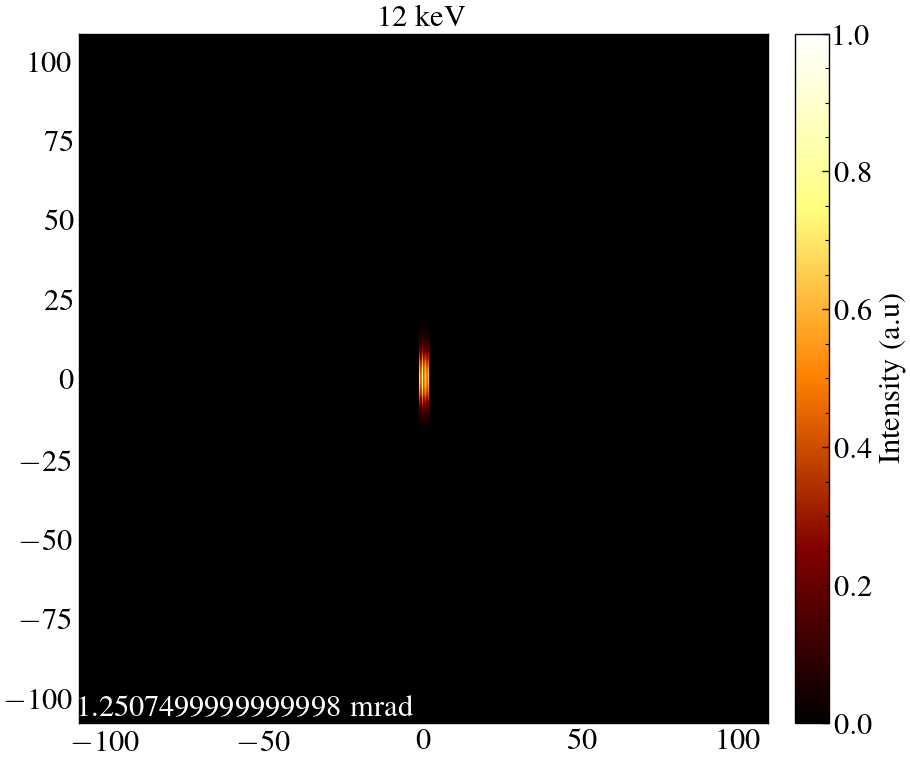

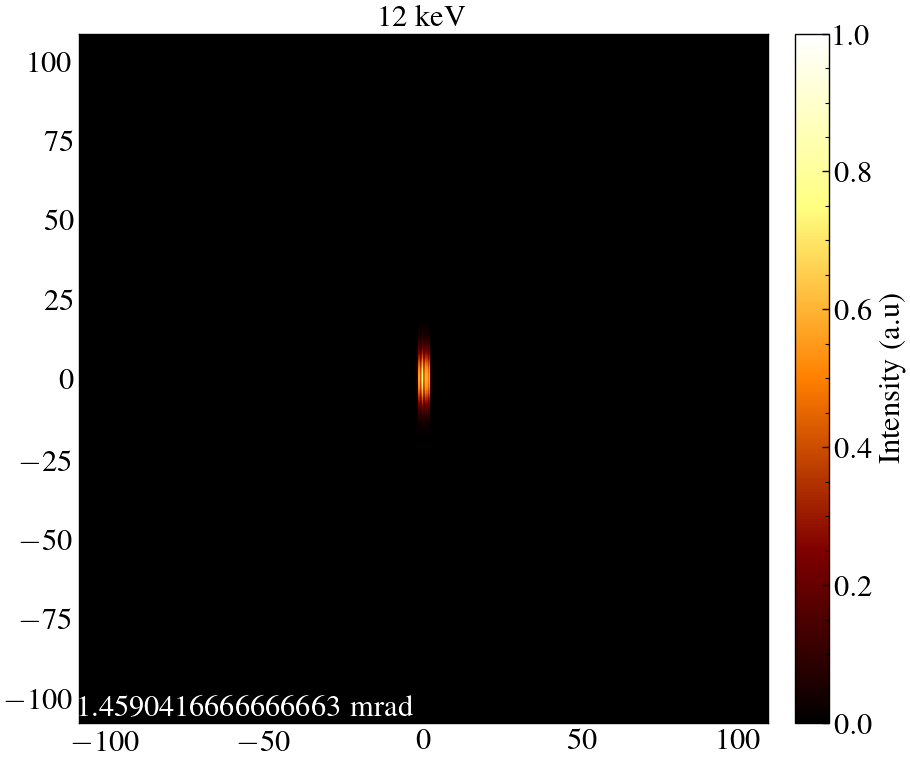

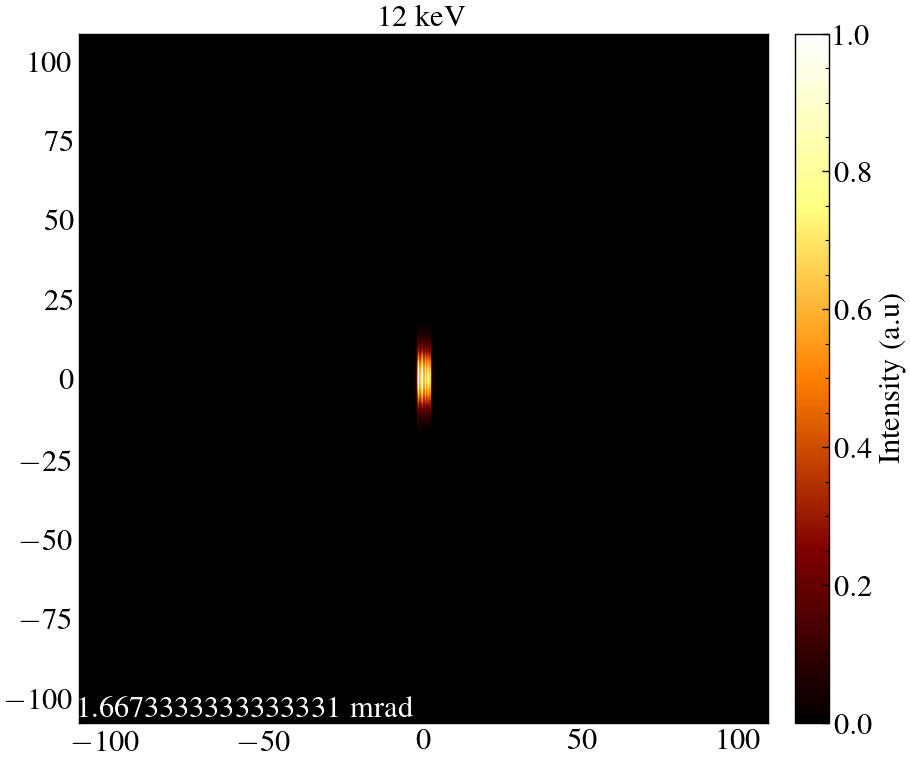

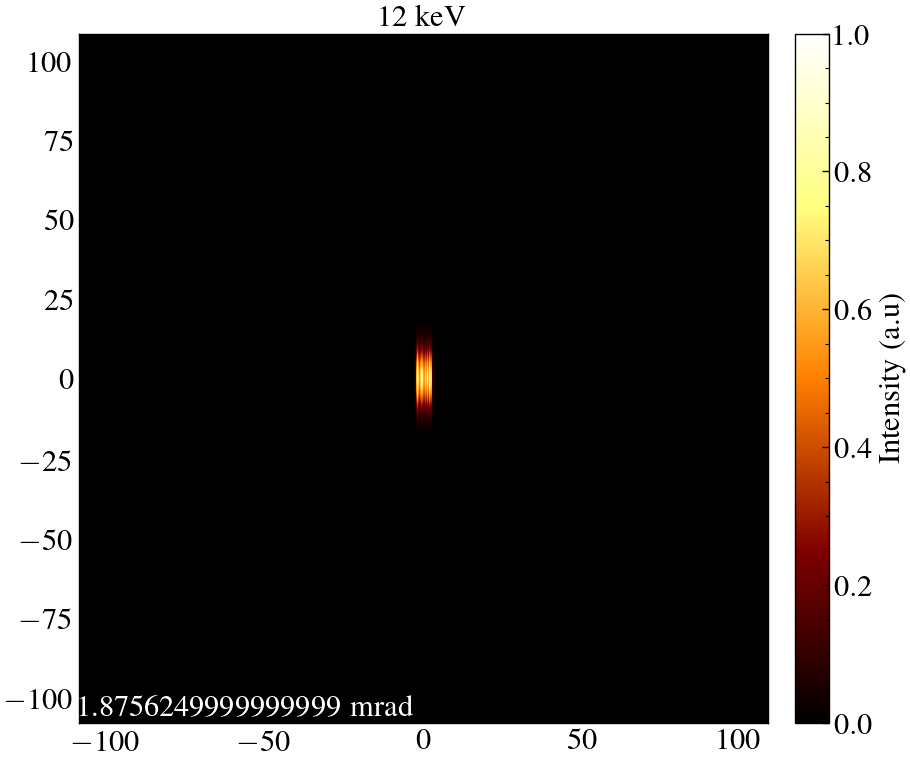

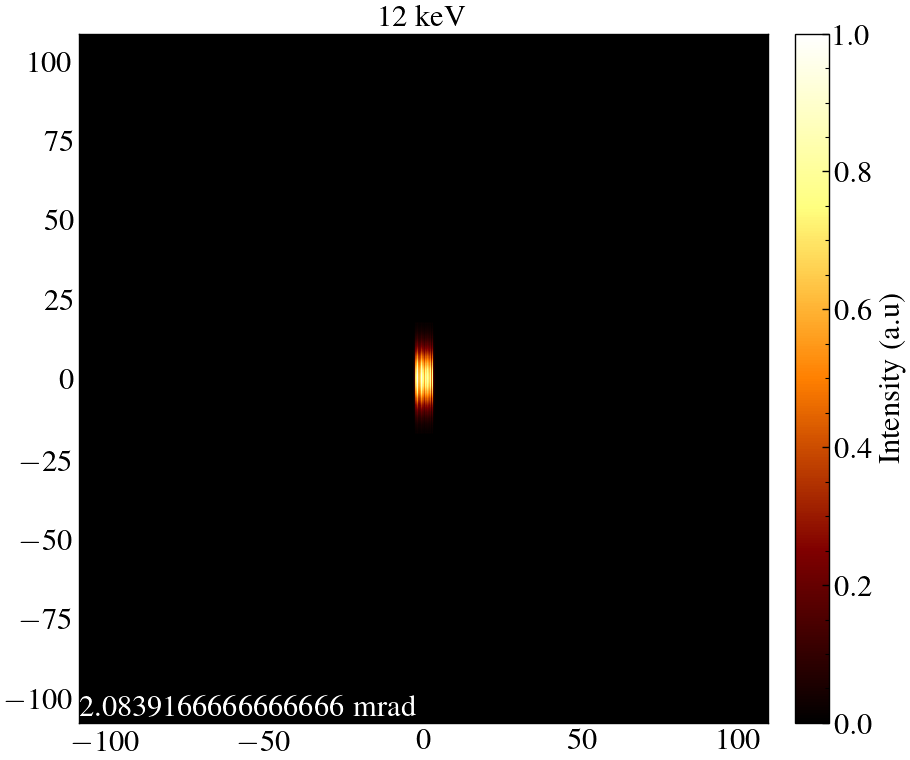

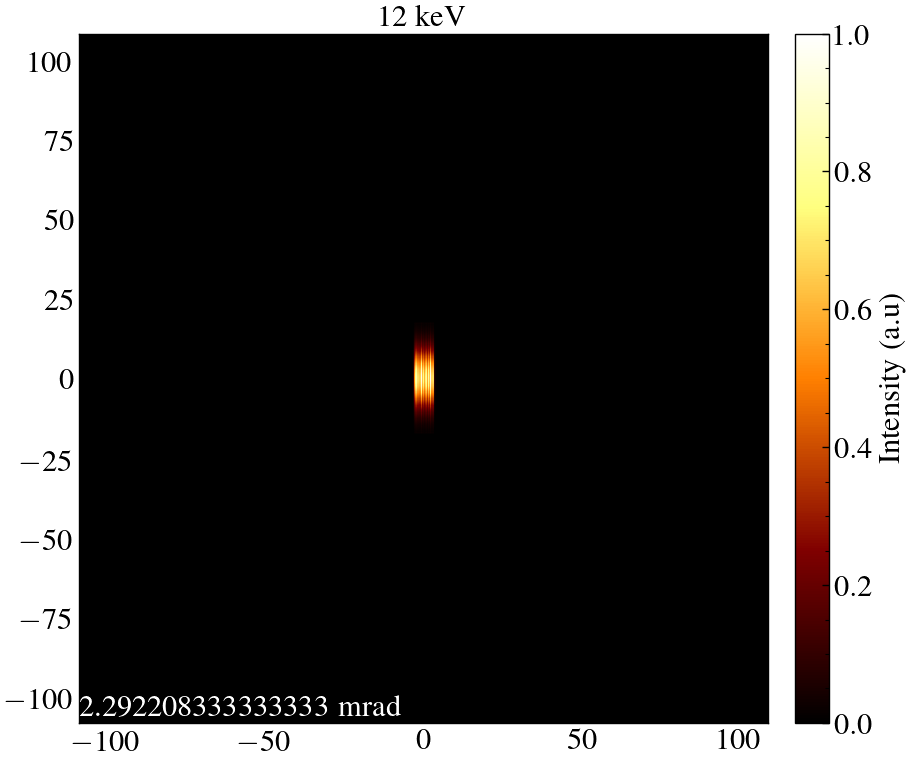

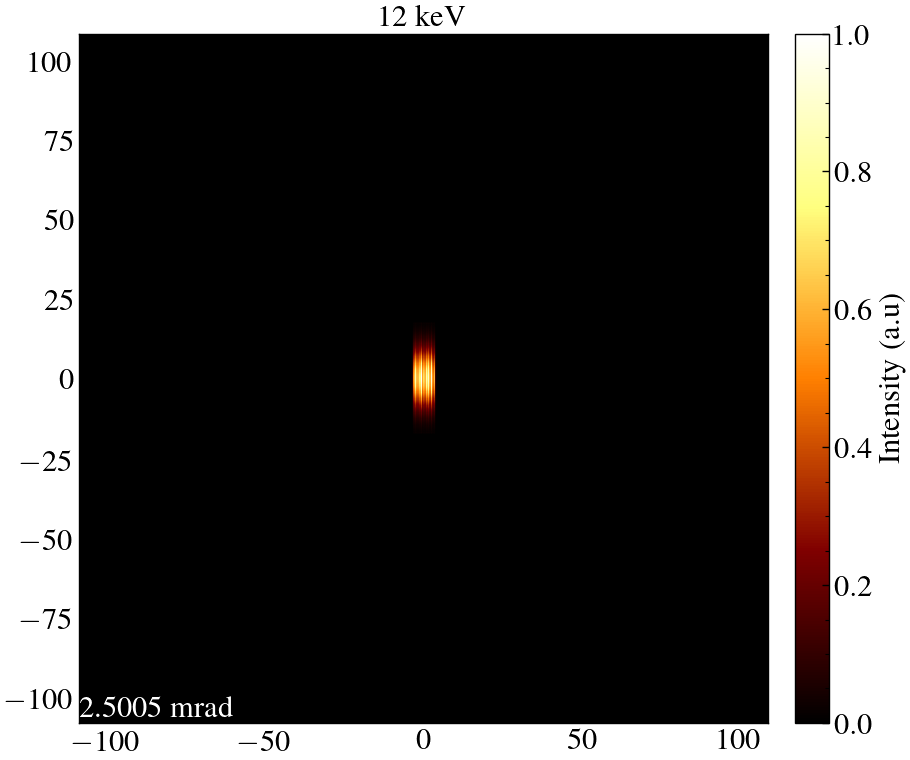

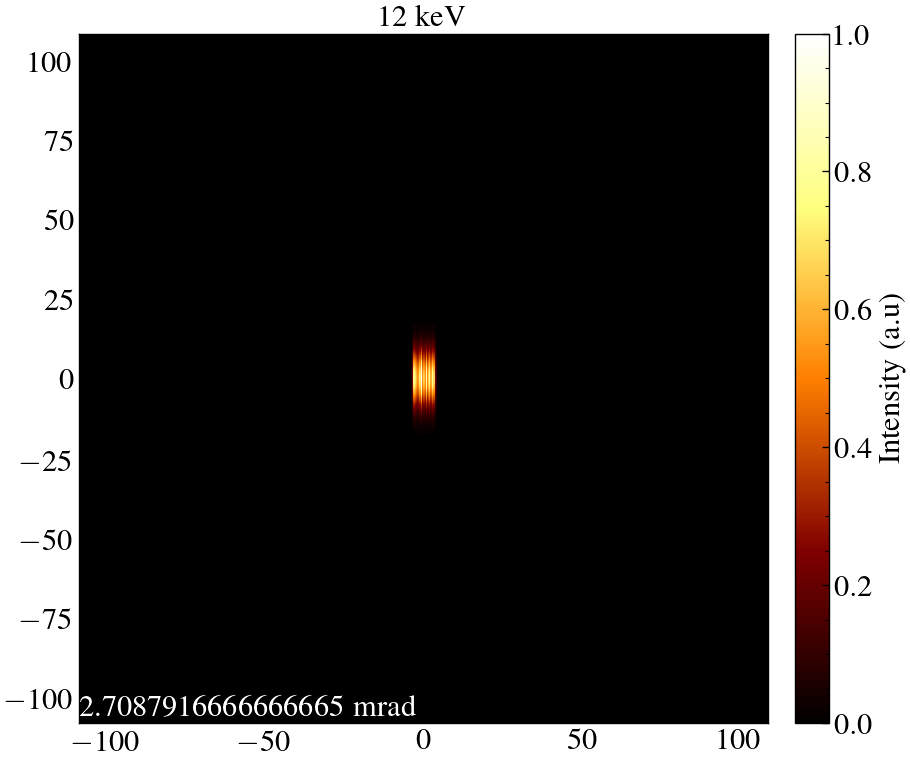

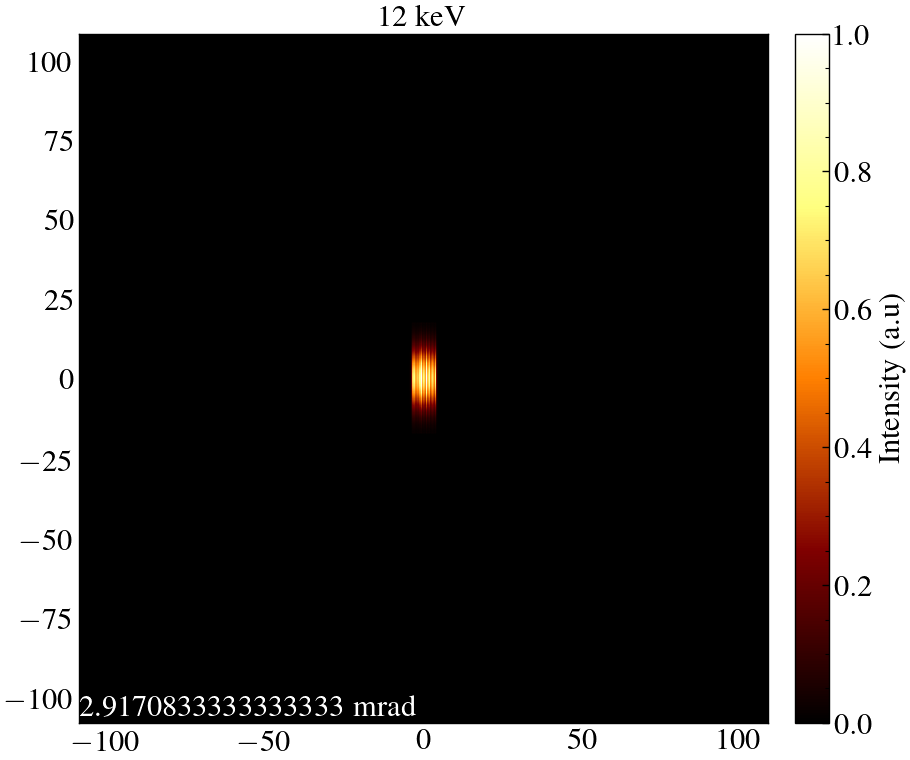

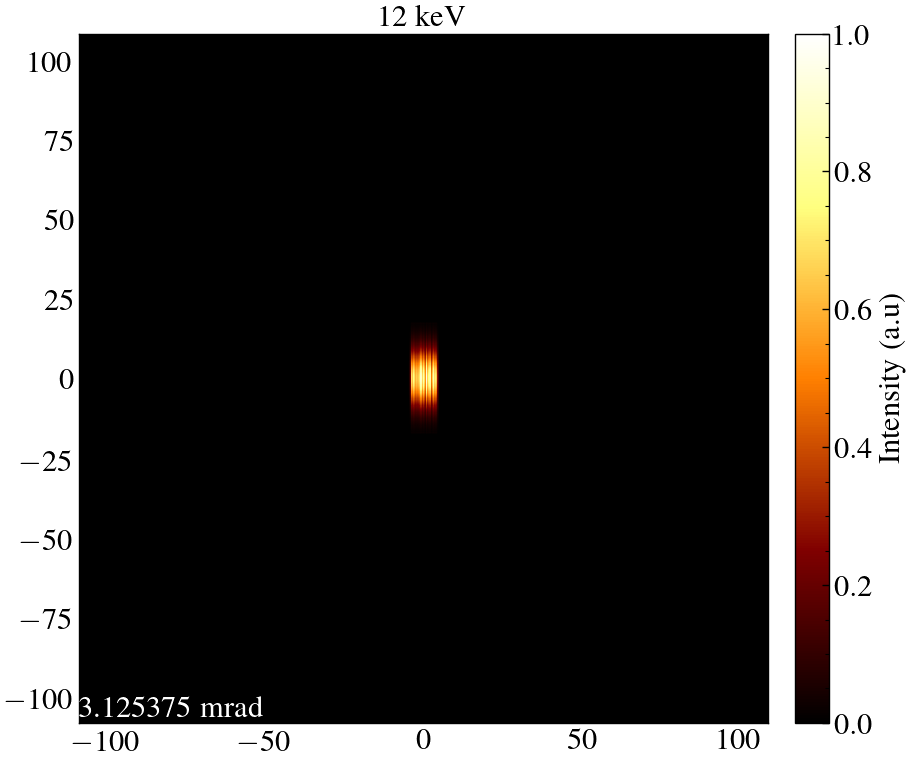

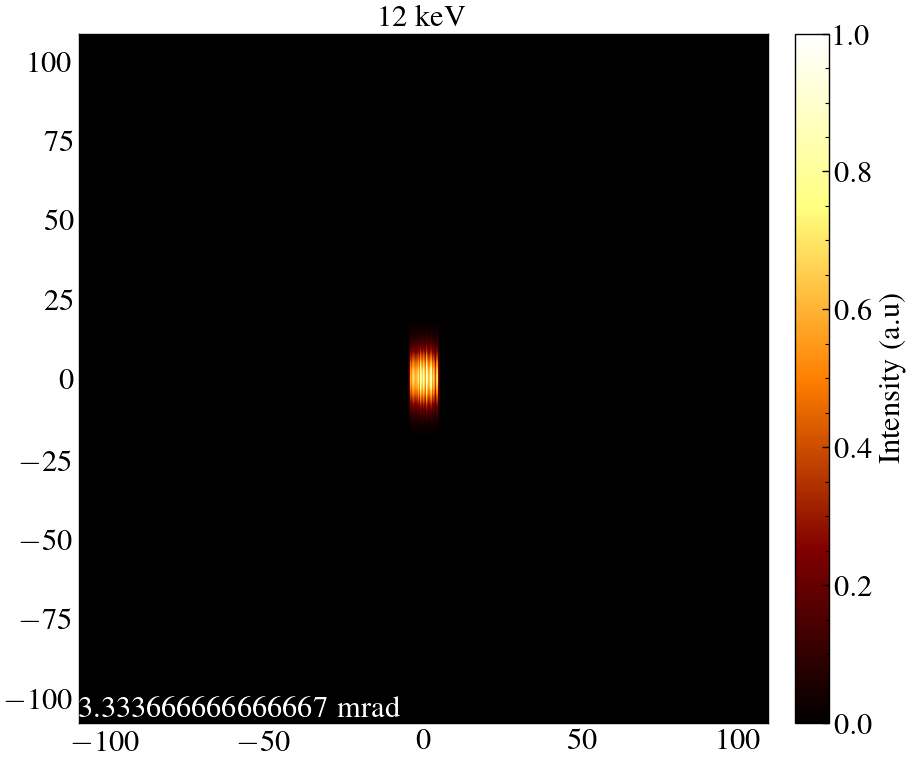

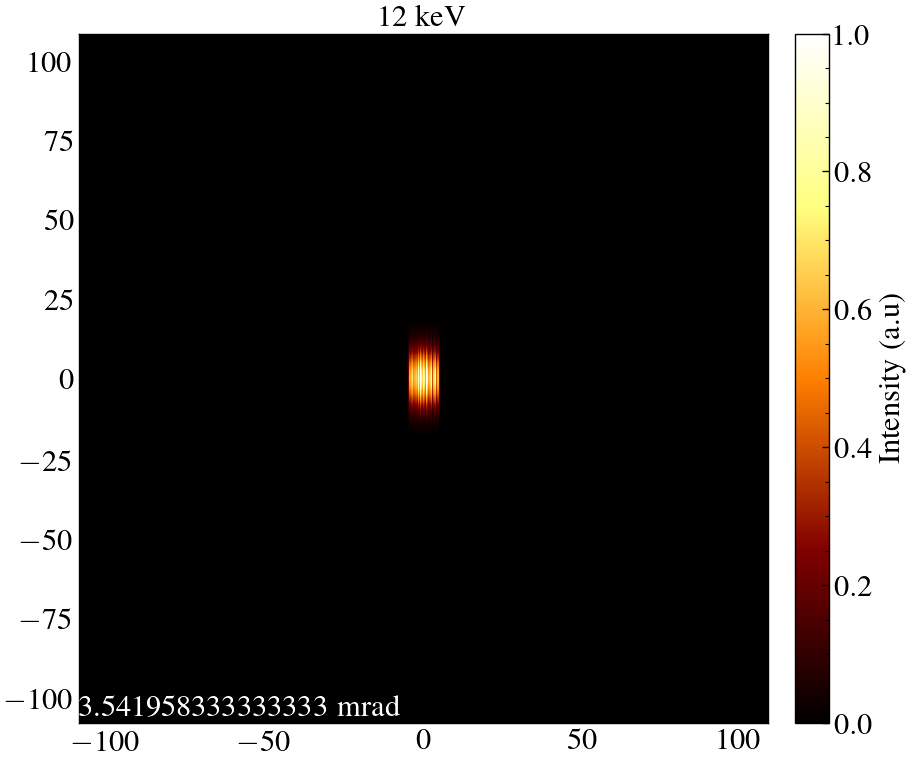

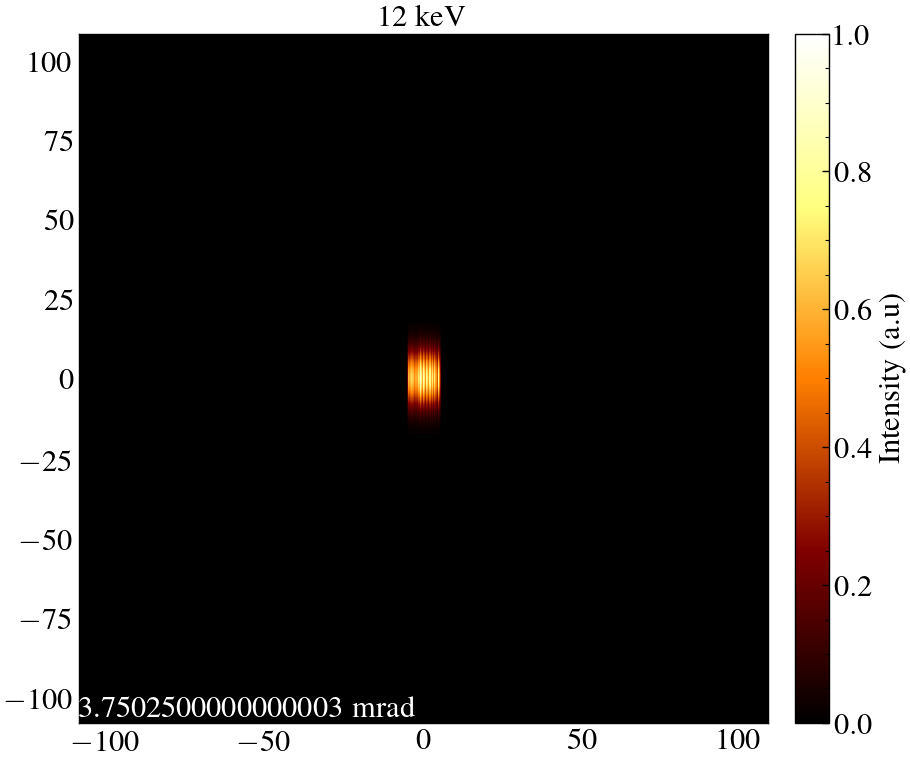

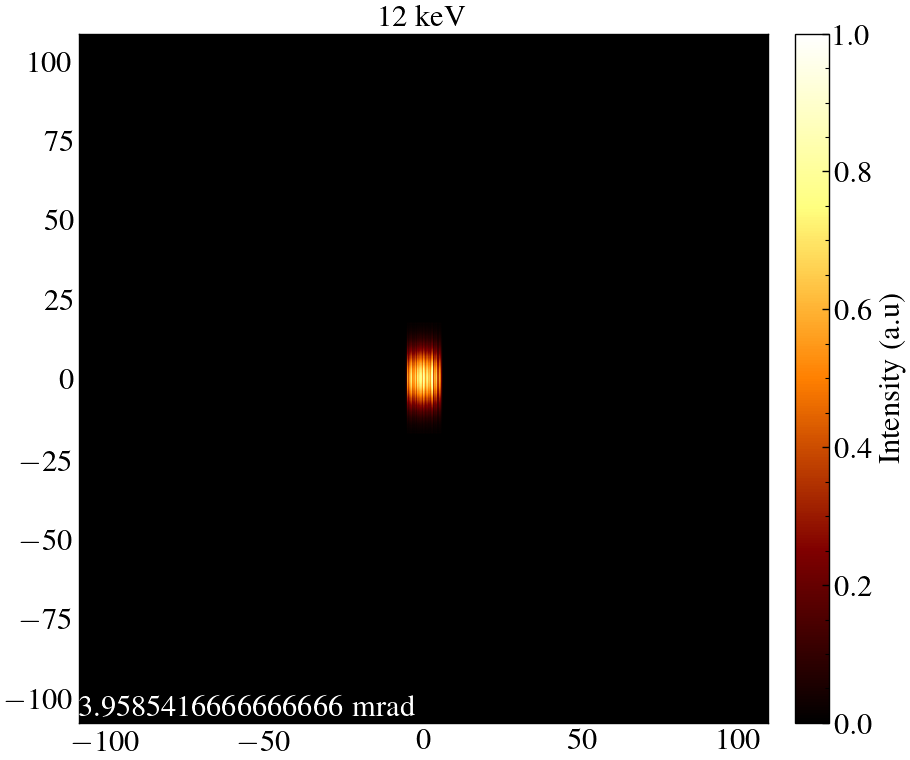

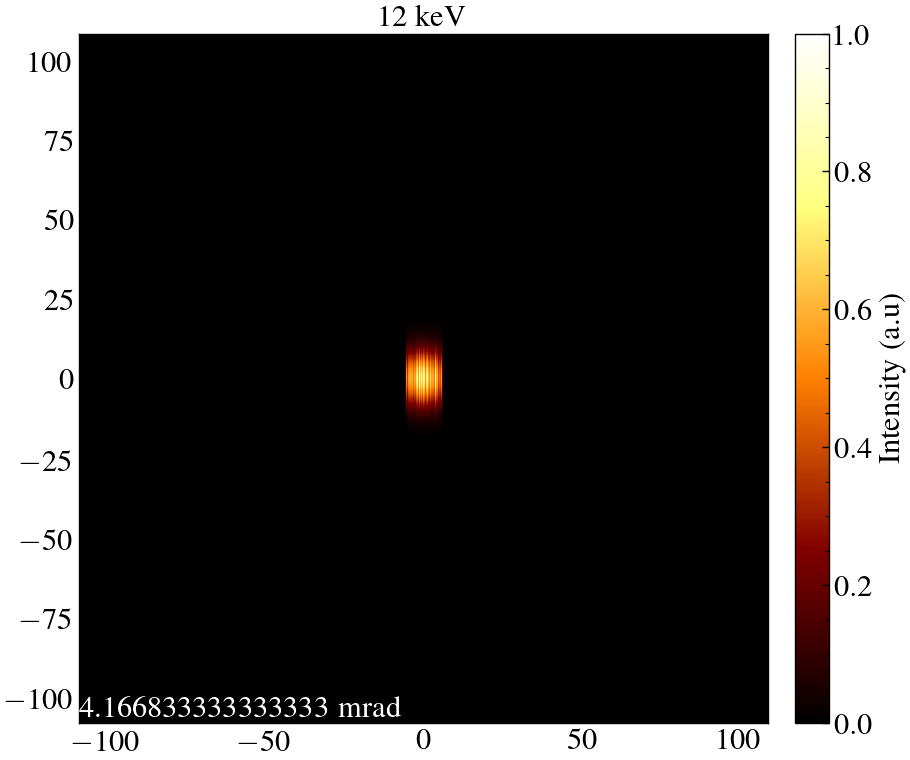

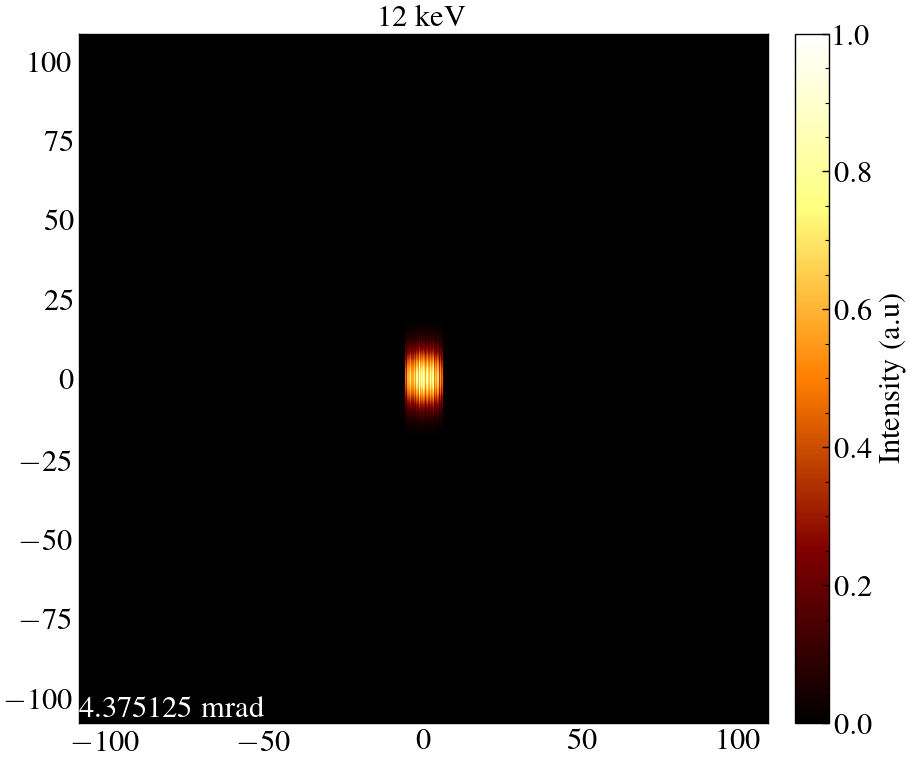

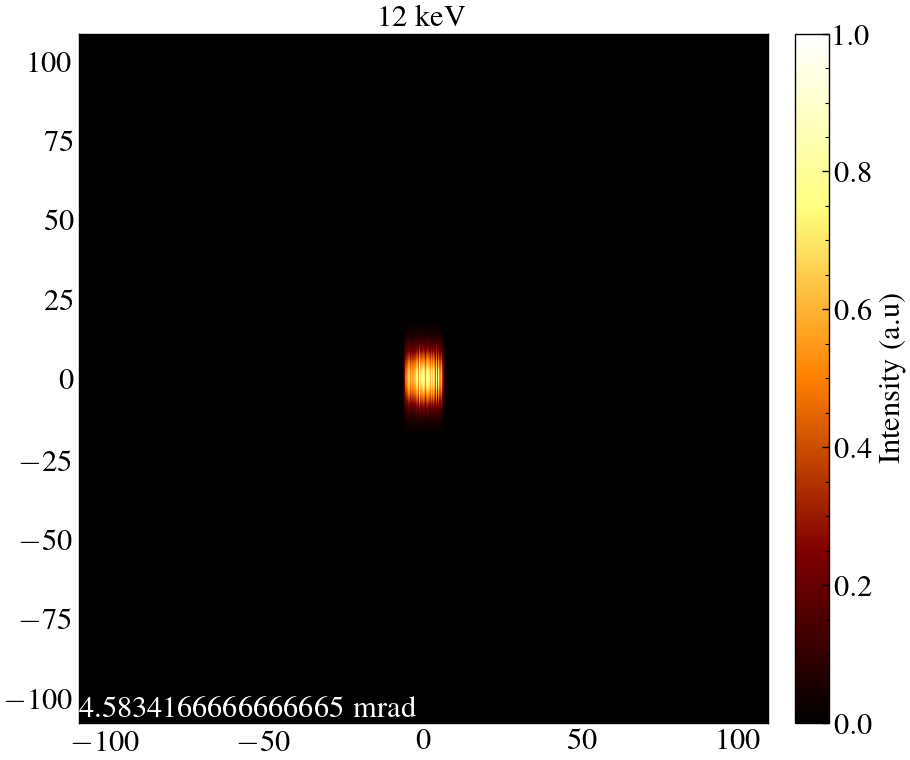

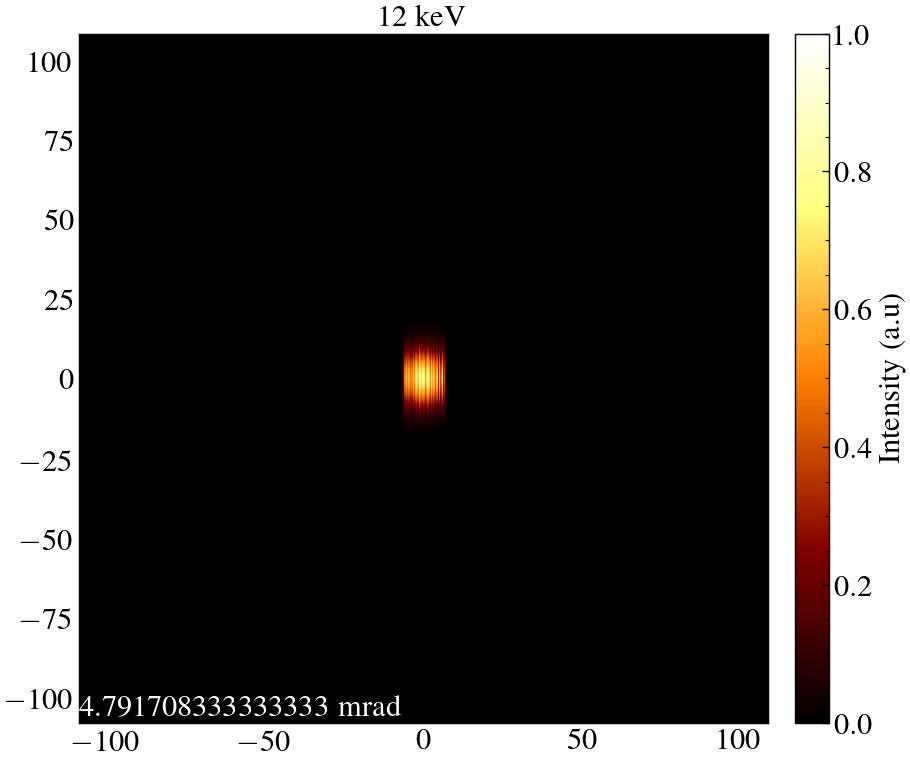

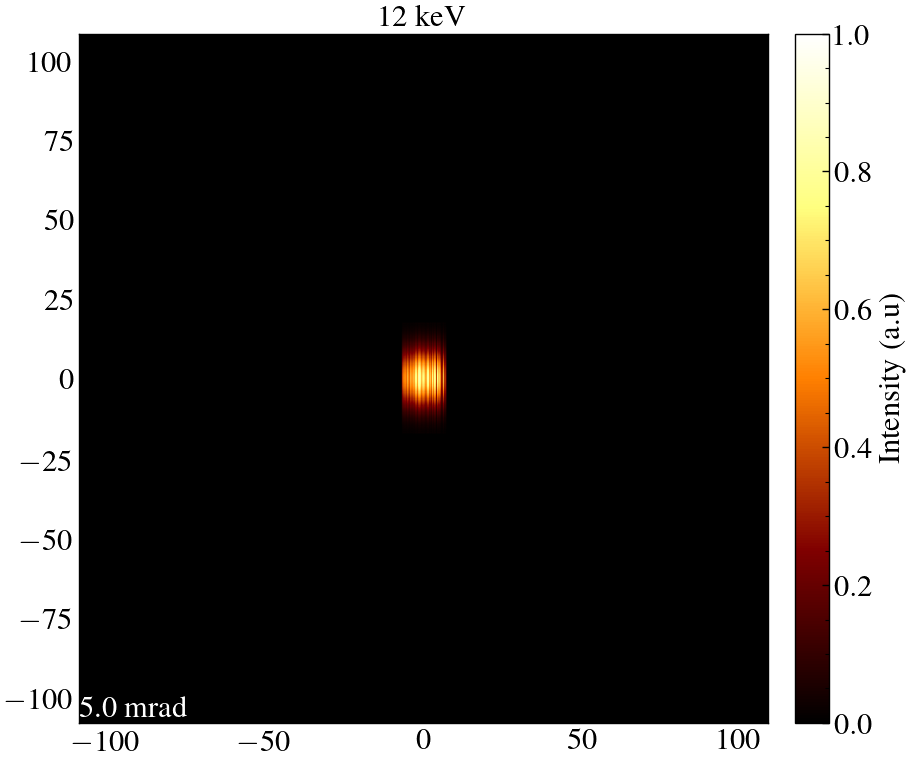

In [3]:
for a in np.linspace(1e-06,5e-03,25):
    plot_downstream(a, 12)

In [3]:
a = np.linspace(1e-03,5e-03, 5)
b = np.linspace(5e-03,10e-03, 20)
c = np.linspace(10e-03,12.5e-03, 10)

angles = np.concatenate((a,b,c))

loop_gti(angles, ekev, ii0)

0it [00:00, ?it/s]

************
Angle: 0.001
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Expected Refl:  0.98625
Actual Refl:  0.98625
Refl w/ Ap:  0.1965955


1it [02:47, 167.93s/it]

************
Angle: 0.002
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


2it [05:36, 168.23s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.971743
Actual Refl:  0.97174287
Refl w/ Ap:  0.35061854
************
Angle: 0.003
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


3it [08:26, 168.73s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.953122
Actual Refl:  0.95312196
Refl w/ Ap:  0.5043243
************
Angle: 0.004
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


4it [11:11, 167.66s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.926048
Actual Refl:  0.926048
Refl w/ Ap:  0.6030714
************
Angle: 0.005
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


5it [13:59, 167.72s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.857524
Actual Refl:  0.85752404
Refl w/ Ap:  0.6562603
************
Angle: 0.005
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


6it [16:48, 168.03s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.857524
Actual Refl:  0.85752404
Refl w/ Ap:  0.6562603
************
Angle: 0.005263157894736842
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


7it [19:35, 167.83s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.809299
Actual Refl:  0.8092988
Refl w/ Ap:  0.64122707
************
Angle: 0.005526315789473685
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


8it [22:26, 168.60s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.622096
Actual Refl:  0.62209594
Refl w/ Ap:  0.50075364
************
Angle: 0.005789473684210527
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


9it [25:10, 167.37s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.316775
Actual Refl:  0.31677496
Refl w/ Ap:  0.26243532
************
Angle: 0.0060526315789473685
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


10it [27:56, 166.93s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.227255
Actual Refl:  0.22725499
Refl w/ Ap:  0.19310974
************
Angle: 0.00631578947368421
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


11it [30:44, 167.28s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.07176602
Actual Refl:  0.07176601
Refl w/ Ap:  0.06235922
************
Angle: 0.006578947368421052
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


12it [33:34, 168.04s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.144277
Actual Refl:  0.14427699
Refl w/ Ap:  0.12663993
************
Angle: 0.006842105263157895
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


13it [36:26, 169.18s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.03990097
Actual Refl:  0.03990097
Refl w/ Ap:  0.0356709
************
Angle: 0.007105263157894737
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


14it [39:13, 168.53s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.07031432
Actual Refl:  0.07031432
Refl w/ Ap:  0.06387453
************
Angle: 0.007368421052631579
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


15it [42:00, 168.15s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.0584002
Actual Refl:  0.05840019
Refl w/ Ap:  0.053435843
************
Angle: 0.0076315789473684215
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


16it [44:50, 168.56s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.01366964
Actual Refl:  0.013669641
Refl w/ Ap:  0.01267134
************
Angle: 0.007894736842105263
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


17it [47:40, 168.94s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.05667263
Actual Refl:  0.05667263
Refl w/ Ap:  0.053129293
************
Angle: 0.008157894736842105
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


18it [50:24, 167.53s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.02593229
Actual Refl:  0.025932286
Refl w/ Ap:  0.02454877
************
Angle: 0.008421052631578947
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


19it [53:10, 167.27s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.0123313
Actual Refl:  0.012331299
Refl w/ Ap:  0.011724276
************
Angle: 0.008684210526315789
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


20it [55:57, 167.11s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.03658406
Actual Refl:  0.036584053
Refl w/ Ap:  0.035054106
************
Angle: 0.008947368421052631
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


21it [58:43, 166.75s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.01396119
Actual Refl:  0.013961189
Refl w/ Ap:  0.013466407
************
Angle: 0.009210526315789475
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


22it [1:01:29, 166.62s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.005495081
Actual Refl:  0.0054950807
Refl w/ Ap:  0.005330384
************
Angle: 0.009473684210526315
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


23it [1:04:18, 167.06s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.0240379
Actual Refl:  0.024037898
Refl w/ Ap:  0.023375744
************
Angle: 0.009736842105263158
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


24it [1:07:05, 167.25s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.01392563
Actual Refl:  0.013925629
Refl w/ Ap:  0.013601855
************
Angle: 0.01
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


25it [1:09:54, 167.85s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.002345687
Actual Refl:  0.0023456872
Refl w/ Ap:  0.0022996732
************
Angle: 0.01
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


26it [1:12:43, 168.01s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.002345687
Actual Refl:  0.0023456872
Refl w/ Ap:  0.0022996732
************
Angle: 0.010277777777777778
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


27it [1:15:31, 167.93s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.0151476
Actual Refl:  0.0151476
Refl w/ Ap:  0.014896777
************
Angle: 0.010555555555555556
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


28it [1:18:18, 167.70s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.01081275
Actual Refl:  0.01081275
Refl w/ Ap:  0.0106481705
************
Angle: 0.010833333333333334
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


29it [1:21:04, 167.39s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.001178654
Actual Refl:  0.001178654
Refl w/ Ap:  0.0011634686
************
Angle: 0.011111111111111112
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


30it [1:23:52, 167.49s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.009349904
Actual Refl:  0.009349904
Refl w/ Ap:  0.009247593
************
Angle: 0.01138888888888889
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


31it [1:26:42, 168.19s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.009343969
Actual Refl:  0.009343969
Refl w/ Ap:  0.0092567075
************
Angle: 0.011666666666666667
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


32it [1:29:32, 168.70s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.001021089
Actual Refl:  0.0010210889
Refl w/ Ap:  0.0010128996
************
Angle: 0.011944444444444445
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


33it [1:32:26, 170.27s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.004026439
Actual Refl:  0.004026439
Refl w/ Ap:  0.003998485
************
Angle: 0.012222222222222223
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


34it [1:35:14, 169.59s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.008306478
Actual Refl:  0.008306477
Refl w/ Ap:  0.00825264
************
Angle: 0.0125
Initialising Single Particle Beamline
List of Elements: ['d1', 'HOM1']
Initialising Single Particle Beamline


35it [1:38:00, 168.03s/it]

List of Elements: ['d1', 'HOM1']
Expected Refl:  0.002496249
Actual Refl:  0.0024962488
Refl w/ Ap:  0.0024820392
func:'loop_gti' took: 5880.9562 sec


In [32]:
from felpy.utils.vis_utils import animate
animate(indir = "./gif_tmp/", outdir = "./", fname = "mirror_rot", rmdir = False, delay = 0.25)
